In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import matplotlib
from roboflow import Roboflow
from PIL import Image
import cv2 
import xml.etree.ElementTree as et
from functools import reduce
from copy import deepcopy

In [2]:
# Only run this if you want to read/write files in parent directory
os.chdir('..')
print(os.getcwd())

C:\Users\Nick\Documents\Classes\Current\Research\NASA


In [3]:
def update_data(version=8, fmt='voc'):
    rf = Roboflow(api_key="OYCys85yUllqTPobA5GG")
    project = rf.workspace("tid-detection").project("nasatiddetect")
    dataset = project.version(version).download(fmt)
    print(f'Saved Version {version} {fmt.upper()} files to folder')
    return

In [4]:
def retrieve_marylou_csv():
    df = pd.read_excel('ImgData.xlsx', index_col=0)
    print(os.listdir('2017_img_plots')[:10])
    four_year_shift = lambda x: x.replace(year = x.year - 4)
    df.index = pd.to_datetime(list(map(four_year_shift, df.index)))
    df.index.name = 'Date'
    df['TID Bool'] = df['TID, MLW'].astype(bool)
    df = df.drop('TID, MLW', axis=1)
    img_fmt = lambda date: f'spots_{date.strftime("%Y-%m-%d")}_T0_B20_RBN_WSPR_PSK_.jpg'
    df['Image Path'] = list(map(img_fmt, df.index))
    return df

In [5]:
def apply_dummy_height(df):
    df['Dummy Y0'] = np.random.normal(20, 5, size=df.shape[0])
    df['Dummy Y1'] = df['Dummy Y0'] + np.random.normal(5, 2, size=df.shape[0])
    def t_fmt(x):
        try:
            flt = float(x)
        except:
            flt = 0.0
        return flt

    df['Start time'] = df['Start time'].apply(t_fmt)
    df['End time'] = df['End time'].apply(t_fmt)
    df['Coords'] = list(zip(df['Start time'].round(1), df['Dummy Y0'].round(1), df['End time'].round(1), df['Dummy Y1'].round(1)))
    return df

In [6]:
def trim_df_for_save(df):
    df.loc[:,'Dummy Y0'] = -1
    df.loc[:,'Dummy Y1'] = -1

    # title case for columns
    df.columns = list(map(lambda x : x.title(), df.columns))

    
    trim_coords = ['xmin','ymin','xmax','ymax','Tid Hours','Cycles','Period','Train Set','Image Path']
    #select only certain columns
    df = df.rename(columns={'Start Time':'xmin','End Time':'xmax','Dummy Y0':'ymin','Dummy Y1':'ymax'}).loc[:,trim_coords]
    df.loc[:,'coords'] = list(zip(df['xmin'], df['ymin'], df['xmax'], df['ymax']))

    #add the 'd' character to the front of dates to prevent autoconversion
    date_prefix = lambda x : 'd' + x.strftime('%m-%d-%Y')
    df.index = list(map(date_prefix, df.index))
    df.index.name = 'Date'
    return df

def split_sets(df):
    set_A_df = df[df['Train Set'] == 'A']
    set_B_df = df[df['Train Set'] == 'B']
    display(set_A_df.head())
    display(set_B_df.head())
    
    set_A_df = trim_df_for_save(set_A_df)
    set_B_df = trim_df_for_save(set_B_df)
    
    set_A_df.to_csv('TID_set_Nick.csv')
    set_B_df.to_csv('TID_set_Lucas.csv')
    return

## Conversions
#### coordinates need to be converted between both plotted & cropped images, as well as between physical height and pixel height

In [8]:
IMG_SIZE = (719, 301, 3)
POSITIONS = ['xmin','ymin','xmax','ymax']
CROP_DIFS = (125, 844, 153, 454)

def uncrop_to_crop_coords(coords):
    xmin, ymin, xmax, ymax = coords
    xmin -= CROP_DIFS[0]
    ymin -= CROP_DIFS[2]
    xmax -= CROP_DIFS[0]
    ymax -= CROP_DIFS[2]
    return xmin, ymin, xmax, ymax

def crop_to_uncrop_coords(coords):
    xmin, ymin, xmax, ymax = coords
    xmin += CROP_DIFS[0]
    ymin += CROP_DIFS[2]
    xmax += CROP_DIFS[0]
    ymax += CROP_DIFS[2]
    return xmin, ymin, xmax, ymax

def convert_hour_to_pixel(hour):
    # converts given hour to cropped pixel width
    scale = IMG_SIZE[0] / 12
    x_loc = scale * hour
    return x_loc

def convert_height_to_pixel(height):
    # converts given physical height to cropped pixel height
    scale = IMG_SIZE[1] / 3000
    y_loc = 3000 - scale * height
    return y_loc

def convert_pixel_to_height(y_loc):
    # converts given cropped vertical pixel location to physical height
    scale = 3000 / IMG_SIZE[1]
    height = 3000 - height * scale
    return height

def convert_pixel_to_hour(x_loc):
    # converts cropped p to cropped pixel width
    scale =  12 / IMG_SIZE[0]
    hour = scale * x_loc
    return hour

def convert_coords_to_pixel(coords):
    xmin, xmax = convert_hour_to_pixel(coords[0]), convert_hour_to_pixel(coords[2])
    ymin, ymax = convert_height_to_pixel(coords[1]), convert_hour_to_pixel(coords[3])
    return xmin, ymin, xmax, ymax
    
def convert_plot_coords(plot_coords, reverse=False):
    if reverse:
        xmin, xmax = plot_coords[0] + 125, plot_coords[2] + 125
        ymin, ymax = plot_coords[1] + 153, plot_coords[3] + 153
    else:
        xmin, xmax = plot_coords[0] - 125, plot_coords[2] - 125
        ymin, ymax = plot_coords[1] - 153, plot_coords[3] - 153
    return xmin, ymin, xmax, ymax

In [ ]:
def copy_elem(elem):
    return et.fromstring(et.tostring(elem))

def print_elem(elem):
    elem = et.tostring(elem)
    elem = elem.decode('utf-8')
    print(elem)
    return

def remove_polygons(tree):
    tree = copy_elem(tree)
    for obj in tree.findall('object'):
        for poly in obj.findall('polygon'):
            obj.remove(poly)
    return tree

def print_tree_no_poly(tree):
    tree = remove_polygons(tree)
    print_elem(tree)
    return

int_round_text = lambda x : int(round(float(x.text), 0)) 
def read_coords(tree):
    coord_list = list()
    for obj in tree.findall('object'):
        for bndbox in obj.findall('bndbox'):
            xmin = bndbox.find('xmin')
            ymin = bndbox.find('ymin')
            xmax = bndbox.find('xmax')
            ymax = bndbox.find('ymax')
            temp_coords = tuple(map(int_round_text, (xmin, ymin, xmax, ymax)))
            coord_list.append(temp_coords)
    return coord_list
    
def replace_bndbox_coords(bndbox, coords):   
    assert len(coords) == len(POSITIONS)
    for pos, coord in zip(POSITIONS, coords):
        bndbox.find(pos).text = coord
    return

def replace_coord(tree, in_coords):
    tree = copy_elem(tree)
    coord_list = list()
    objs = tree.findall('object')
    assert len(objs) == 1
    bndboxs = objs[0].findall('bndbox')
    assert len(bndboxs) == 1
    replace_bndbox_coords(bndboxs[0], in_coords)
    return tree

def read_img_size(tree):
    sizes = tree.find('size')
    img_size_list = list()
    for size in sizes:
        img_size_list.append(int(size.text))
    img_size = tuple(img_size_list)
    return img_size

#     generic_obj = et.fromstring(et.tostring(generic_obj).decode('utf-8').replace('\n<object>','\n    <object>'))
def append_coords(tree, coordss, print_bool=False, suffix='_augmented.xml'):
#     tree = et.parse(filename)
#     tree = remove_polygons(tree)
    root = tree.getroot()
    objs = tree.findall('object')

    if print_bool: print_elem(tree.getroot())

    for coords in coordss:
        generic_obj = deepcopy(tree.find('object'))
        bndbox = generic_obj.find('bndbox')
        
        for position, coord in zip(POSITIONS, coords):
            bndbox.find(position).text = str(coord)
        
        tree.getroot().append(generic_obj)

    if print_bool: print_elem(tree.getroot())
        

    return tree

def split_date(path):
    file_name = path.split('/')[-1]
    date = file_name.split('_')[0]
    date = pd.to_datetime(date)
    return date

['2017-01-02_plot_cropped_jpg.rf.0a79b7625f594c3e8485b42a7f0a83a1.jpg', '2017-01-02_plot_cropped_jpg.rf.0a79b7625f594c3e8485b42a7f0a83a1.xml', '2017-01-03_plot_jpg.rf.729d0233891b7d141098b0b5cc442dc9.jpg', '2017-01-03_plot_jpg.rf.729d0233891b7d141098b0b5cc442dc9.xml', '2017-01-05_plot_cropped_jpg.rf.d79913bb35924a05da346c5089119813.jpg', '2017-01-05_plot_cropped_jpg.rf.d79913bb35924a05da346c5089119813.xml', '2017-01-06_plot_jpg.rf.914d489609481e29a64b3bbc5b4283b7.jpg', '2017-01-06_plot_jpg.rf.914d489609481e29a64b3bbc5b4283b7.xml', '2017-01-07_plot_cropped_jpg.rf.ea9d05f49789f4f77ee18ecf942a0941.jpg', '2017-01-07_plot_cropped_jpg.rf.ea9d05f49789f4f77ee18ecf942a0941.xml']
(263, 105, 653, 208)
2017-01-02
(282, 252, 795, 372)
2017-01-03
(479, 102, 717, 199)
2017-01-05
(307, 216, 729, 368)
2017-01-06
(237, 107, 637, 245)
2017-01-07
(300, 249, 660, 358)
2017-01-13
(226, 96, 720, 234)
2017-01-15
(247, 255, 549, 383)
2017-01-18
(214, 115, 564, 236)
2017-01-19
(193, 249, 668, 377)
2017-01-20
(1

,xmin,ymin,xmax,ymax
Date,,,,
2017-01-02,263,1953.488372,653,926.910299
2017-01-03,157,2013.289037,670,817.275748
2017-01-05,479,1983.388704,717,1016.611296
2017-01-06,182,2372.093023,604,857.142857
2017-01-07,237,1933.554817,637,558.139535
...,...,...,...,...
2017-12-23,183,2272.425249,470,787.375415
2017-12-24,159,1684.385382,556,578.073090
2017-12-25,120,2571.428571,720,737.541528


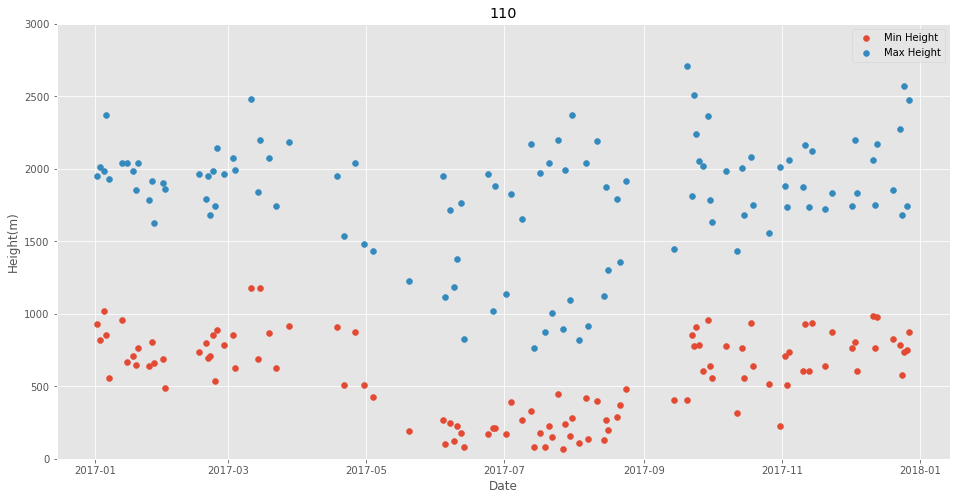

In [19]:
def transform_coords(coords, cycle_markers):
    cycle_markers.sort()
    xmin, ymin, xmax, ymax = coords
    for coord in coords:
        assert isinstance(coord, (int, float))
    a1 = (xmin, ymin, xmax, ymax)
    augmentations = [a1] # initialize list with first argument as raw coords
    first_period = cycle_markers[1]
    
    # add first period + eighths to bounding box
    for a_xmax in np.linspace(first_period, xmax, 8):
        new_a = (xmin, ymin, a_xmax, ymax)
        augmentations.append(new_a)
    scale = IMG_SIZE[0] / 12
    
    for i in range(5):
        new_a = (xmin + scale * np.random.uniform(0,1), ymin, xmax, ymax)
        augmentations.append(new_a)   
    
    for i in range(1, len(cycle_markers)):
        a_xmin = cycle_markers[i - 1]
        a_xmax = cycle_markers[i]
        new_a = (a_xmin, ymin, a_xmax, ymax)
        augmentations.append(new_a)
        
    for y_scale in [1.25, 1.5, 1.75]:
        dy = ymax - ymin
        yavg = (ymax + ymin) / 2
        dy = y_scale * dy
        a_ymax = yavg + dy / 2
        a_ymin = yavg - dy / 2
        new_a = (xmin, a_ymin, xmax, a_ymax)
        augmentations.append(new_a)
    
    print('number of augmented coords:', len(augmentations))
    return augmentations

def augment_coords_df(tid_df, conversion='hour'):
    # conversion in 'hour', 'plot', None
    for index, row in tid_df.iterrows():
        filename = row['Image Path'].replace('.jpg','.xml')
        coords = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        
        if conversion == 'hour': coords = convert_coords_to_pixel(coords)
        elif converison == 'plot': coords = convert_plot_coords(coords)
            
        coordss = transform_coords(coords)
        append_coords(filename, coordss)

def visualize_xml(img_path, xml_path):
#     img = Image.open(img_path)
    print('Visual XML path', xml_path)
    img = cv2.imread(img_path)
    plt.imshow(img[:,:,::-1])
    plt.show()
    tree = et.parse(xml_path)
    coordss = read_coords(tree)  
    for coords in coordss:
        new_img = img.copy()
        xmin,ymin,xmax,ymax = map(int_round, coords)
#         xc, yc = (xmin + xmax) / 2, (ymin + ymax) / 2
#         w, h = (xmax - xmin), (ymax - ymin)
        print(xmin, ymin, xmax, ymax)
        new_img = cv2.rectangle(new_img, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)
        plt.imshow(new_img[:,:,::-1])
        plt.show()
        
def read_imgs_and_xml(directory):
    img_paths = [directory + '/' + file for file in sorted(os.listdir(parent_dir)) if file.endswith('.jpg')]
    xml_paths = [directory + '/' + file for file in sorted(os.listdir(parent_dir)) if file.endswith('.xml')]
    return img_paths, xml_paths

def read_coords_from_dir(directory):
    img_paths, xml_paths = read_imgs_and_xml(directory)
    coord_list, date_list = list(), list()
    for img_path, xml_path in zip(img_paths, xml_paths):
        tree = et.parse(xml_path)
        root = tree.getroot()
        img_size = read_img_size(tree)
        coords = read_coords(tree)[0]
        print(coords)
        if img_size == (1000, 600, 3):
            coords = uncrop_to_crop_coords(coords)
        coord_list.append(coords)
        date = img_path.split('/')[-1].split('_')[0]
        date_list.append(date)
        print(date)
    coord_df = pd.DataFrame(index=pd.to_datetime(date_list))
    coord_df.index.name = 'Date'
    coord_df['xmin'], coord_df['ymin'], coord_df['xmax'], coord_df['ymax'] = zip(*coord_list)
    return coord_df



coord_df = read_coords_from_dir('NasaTIDDetect-8/train')
coord_df['ymax'] = coord_df['ymax'].apply(convert_pixel_to_height)
coord_df['ymin'] = coord_df['ymin'].apply(convert_pixel_to_height)

def min_max_height_plot(coord_df):
    matplotlib.style.use('ggplot')
    plt.figure(figsize=(16,8))
    plt.scatter(coord_df.index, coord_df.ymax, label='Min Height')
    plt.scatter(coord_df.index, coord_df.ymin, label='Max Height')
    plt.ylabel('Height(m)')
    plt.xlabel('Date')
    plt.title(coord_df.shape[0])
    plt.ylim(0, 3000)
    plt.legend()
    plt.show()
    coord_df.loc[:,['ymin','ymax']].rename(columns={'ymin':'Max Height(m)','ymax':'Min Height(m)'}).to_csv('temp.csv')
    return

In [10]:
# visualize_xml('2017_img_plots_set_A_cropped/2017-01-02_plot_cropped.jpg', 'test_case1output.xml')
IMG_SIZE = (719, 301)

img_paths, xml_paths = read_imgs_and_xml(DIRECTORY)
for img_path, xml_path in zip(img_paths, xml_paths):
    tree = et.parse(xml_path)
    date = split_date(img_path)

    n_cycles = df.loc[date,'cycles']
    coords = read_coords(tree)
    if np.array(coords).ndim > 1: coords = coords[0]
    cycle_markers = np.linspace(coords[0], coords[1], n_cycles)
    augmentations = transform_coords(coords, cycle_markers)
    tree = append_coords(xml_path, augmentations)
    new_xml_path = xml_path.replace('.xml','_augmented.xml')
    tree.write(new_xml_path)
    visualize_xml(img_path, new_xml_path)

NameError: name 'set_A_df' is not defined

In [20]:
!ls

10_14_pull_height.csv
2017_gray_img_plots_set_A_cropped
2017_gray_img_plots_set_B_cropped
2017_img_csvs
2017_img_plots
2017_img_plots_set_A
2017_img_plots_set_A_cropped
2017_img_plots_set_B
2017_img_plots_set_B_cropped
2017_img_plots_zipped
CompareHamBeaconTIDs.xlsx
DataHandling
DatabaseRetrieve
ImgData.xlsx
NasaTIDDetect-8
Notebooks
TID_set_Lucas.csv
TID_set_Nick.csv
TIDs_DataFrame.csv
sample_plot_csv.csv
training_labeled
wsprspots-2017-01.csv


In [ ]:
import shutil

color_augmentations('NasaTIDDetect-8/train','NasaTIDDetect-8/augmented_train', coord_aug_pipeline=transform_coords, description='coord_transforms')
def color_augmentations(
    src_dir, 
    target_dir, 
    img_aug_pipeline=None, 
    coord_aug_pipeline=None, 
    description='color_augment', 
    plot_bool=True, 
    grayscale=False, 
    target_size=None,
    clear_tree=False,
):

    today = pd.to_datetime('today').strftime('%m-%d-%y')
    if not os.path.exists(target_dir): 
        print('Creating Directory: ', target_dir)
        os.mkdir(target_dir) 
    img_paths, xml_paths = read_imgs_and_xml(DIRECTORY)
    for img_path, xml_path in zip(img_paths, xml_paths):
        date = split_date(img_path)
        
        img = read_img(img_path)
        tree = et.parse(xml_path)
        
        if img.shape == (1000,600,3): 
            img = crop_plotted_img(img, grayscale=grayscale)
        if target_size and img.shape != target_size:
            assert len(target_size) == 3
            img = img.resize(target_size)
            size_elem = tree.find('size')
            size_elem.find('width').text = target_size[0]
            size_elem.find('height').text = target_size[1]
            size_elem.find('depth').text = target_size[2]
        #~~~~~~~~~~~~~~~~~~~~~#
        if img_aug_pipeline: 
            img = img_aug_pipeline(img)
        #~~~~~~~~~~~~~~~~~~~~~#
        if coord_aug_pipeline:
            coordss = read_coords(tree)
            coordss = coord_aug_pipeline(coordss)
            if clear_tree:
                for obj in tree.findall('object'):
                    tree.remove(obj)
            tree = append_coords(coordss)
        #~~~~~~~~~~~~~~~~~~~~~#
        description = description.replace(' ','_')
        try:
            tree.find('source').find('database').text = f'{description} augmented {today}'
        except:
            pass
        img_file_name = '_'.join([date, description, f'{today}.jpg']
        xml_file_name = '_'.join([date, description, f'{today}.xml']
        for path_str in ['filename','path']:
            path = tree.find('filename')
            path.text = img_file_name

        new_img_path = os.path.join(target_dir, img_file_name)
        new_xml_path = os.path.join(target_dir, xml_file_name)
        tree.write(new_xml_path)       
        img.save(new_img_path)
                        
        print(date)
        if plot_bool: visualize_xml(new_img_path, new_xml_path)
    print('Completed without error')
    return

In [ ]:
parent_dir = '2017_img_plots_set_A/'
new_dir = '2017_gray_img_plots_set_A_cropped/'
for img_path in os.listdir(parent_dir):

def read_img(img_path, rgb=True):
    if rgb:
        img = cv2.imread(img_path)
    else:
        img = cv2.imread(img_path)[:,:,::-1]
    return img

def crop_plotted_img(img, grayscale=False):
    assert img.shape == (1000,600,3)
    img = img[CROP_DIFS[2]:CROP_DIFS[3],CROP_DIFS[0]:CROP_DIFS[1]]
    img_patch = img[0:100,0:200]
    img_patch[np.where((img_patch > [30,30,30]).all(axis=-1))] = [0,0,0]
    if grayscale: img = np.expand_dims(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), axis=2)
    return img

In [ ]:
from IPython.display import Image
from shutil import move

# PARENT_DIR = '2017_img_plots_set_B/'
# if not os.path.exists(PARENT_DIR): os.mkdir(PARENT_DIR)

# for date in set_B_df.index:
#     img_path = img_fmt(date)
#     full_path = f'2017_img_plots/{img_path}'
#     new_path = f'{PARENT_DIR}{date.strftime("%Y-%m-%d")}_plot.jpg'
#     try:
#         move(full_path, new_path)
#     except FileNotFoundError as fnfe:
#         print(fnfe)

In [ ]:
!ls
plot_df = pd.read_csv('practice_data.csv')
arr = plot_df.transpose().iloc[::-1].to_numpy()

def plot_tid_map(arr):
    aratio = arr.shape[0] / arr.shape[1]
    w = 16
    h = w * aratio
    plt.figure(figsize=(w,h))
    sns.heatmap(arr)
    plt.show()
    sns.kdeplot(x=df.sepal_width, y=df.sepal_length)
    plt.show()
    
plot_tid_map(arr)

In [ ]:
import cv2
from pykuwahara import kuwahara

# image = cv2.imread('lena_std.jpg')
from skimage import filters
# from skimage.data import camera
from skimage.util import compare_images

edge_roberts = filters.roberts(arr)
edge_sobel = filters.sobel(arr)

filt1 = kuwahara(arr, method='gaussian', radius=9)
_, filt1 = cv2.threshold(arr,7,255,cv2.THRESH_BINARY)
plot_tid_map(filt1)
plot_tid_map(filters.roberts(filt1))
plot_tid_map(edge_roberts)
plot_tid_map(edge_sobel)


In [ ]:
def process_csv(csv_path = '2017-01-03_PSK.csv', wvlen='20m'):
    chunksize = 10 ** 4
    chunk_list = list()
    quote_strip = lambda x : str(x).replace("'",'')
    with pd.read_csv(csv_path, chunksize=chunksize, usecols=[0,21,22], names=['Date','Wavelength','Height']) as reader:
        for chunk in reader:
            chunk['Wavelength'] = chunk['Wavelength'].apply(quote_strip)
            chunk = chunk.set_index('Date')
            chunk.index = pd.to_datetime(chunk.index)
            chunk = chunk.loc[chunk['Wavelength'] == wvlen,:]
            chunk_list.append(chunk.drop('Wavelength', axis=1))
    filtered_df = pd.concat(chunk_list, axis=0)
    return filtered_df

df = process_csv()
display(df)

In [ ]:
plt.figure(figsize=(15,5))
sns.scatterplot(x='Date', y='Height', data=df, alpha=.5)
display(df)

In [ ]:
heatmap, xedges, yedges = np.histogram2d(df.index.to_numpy().ravel(), df['Height'].to_numpy().ravel(), bins=(1000, 400))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]



In [ ]:
def ImageAug():
    def __init__(self, callables):
        self.callables = callables
        
    def __call__(self, img):
        for call in self.callables:
            img = call(img)
        return img
    
    def plot_transforms(self, img):
        plt.imshow(img)
        plt.show()
        for call in self.callables:
            plt.imshow(img)
            plt.show()
            img = call(img)
        return img